# Capacity of Generative Face Models

This notebook demonstrates the procedure for estimating the capacity of generative face models as described in the paper titled "On the Biometric Capacity of Generative Face Models."

In [1]:
import math

from utils import load_features, get_parameters
from capacity_estimation import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The idea is to represent the generated face images in a hyperspherical space, i.e., $\|z\|=1$, and estimate capacity as a ratio of hyper-spherical caps corresponding to all classes (inter-class variance) and a single class (intra-class variance).

![alt text](assets/overview.png "Capacity estimation overview")

# Capacity for unconditional generative models

First, we choose generative face and face representation models and load the features. For example, we load ArcFace features for StyleGAN3.

In [2]:
X, df = load_features('stylegan3', 'arcface', metadata_file=None, root_path=None)

max_samples = 10000 # set this to save memory
if X.shape[0] > max_samples:
    X = X[:max_samples, :]
    df = df[:max_samples]

We estimate capacity as a ratio of hyper-spherical caps corresponding to all classes (inter-class variance) and a single class (intra-class variance).

![alt text](assets/capacity-estimation-concept.png "capacity estimation concept for hyper-spherical representation space")

For the general case of a $n$-dimensional representation space, the ratio of hyper-spherical caps with solid angles $\Omega_1$ and $\Omega_2$ is,

$$
C(\Omega_1, \Omega_2) = \frac{I_{sin^2(\Omega_1)}\left(\frac{n-1}{2},\frac{1}{2}\right)}{I_{sin^2(\Omega_2)}\left(\frac{n-1}{2},\frac{1}{2}\right)}    
$$

The key challenge here is accurately estimating the inter-class ($\Omega_1$) and intra-class ($\Omega_2$) angles.

## Assumptions

Before we proceed, we list the assumptions made by our proposed solution to estimate capacity.

- We estimate capacity within a feature space such as ArcFace and AdaFace. The capacity estimate is for a combination of a generative model and a feature extractor. However, this is a well-justified choice. First, raw image pixels entangle identity and geometric and photometric variations. Moreover, since we aim to estimate capacity w.r.t. unique identities instead of unique images, we need to calculate capacity in a representation space that preserves identity while being invariant to other factors. Thus, a face recognition system’s feature space is a well-justified representation choice.

- We estimate the inter-class and intra-class solid angle support from the furthest distance between all the respective samples. So, we inherently assume that the generated samples span the whole representation space within the estimated support. In practice, there may be regions of low feature density, which our approach ignores. Nonetheless, our capacity estimates are upper bounds of the actual capacity and thus still valuable to practitioners and researchers alike.

- We use a single estimate of the intra-class variance to compute capacity. However, classes typically differ in their intra-class variance due to inherent class properties or the number of samples per class.

### Intra-class variance for unconditional generative models

For unconditional models, we have no control over generating images of a desired class (identity) label, and we do not have class labels for the images. So, we cannot estimate the solid angle $\Omega_2$ corresponding to the intra-class hyper-spherical cap. To overcome this challenge, we use the threshold corresponding to 0.1% FAR on a standard known dataset like LFW as the intra-class variance.

In [3]:
intra_class_angle, _, _, threshold = get_parameters('arcface', 'lfw')
cos_value = math.cos(math.acos(intra_class_angle) / 2) # we take half-the angle since the formula is for the cosine of the half-angle
intra_class_angle = np.arccos(cos_value) # in radians
print("Intra-class angle is {:.2f} radians".format(intra_class_angle))

Intra-class angle is 0.68 radians


From the features, we estimate the inter-class solid angle spanned by all images. To account for outliers, we ignore 5% of the similarity scores.

In [4]:
total_angle, _1, _2 = get_cosine_bounds(X, quantile=0.05)
inter_class_angle = total_angle / 2
inter_class_angle = inter_class_angle * np.pi / 180 # in radians
print("Inter-class angle is {:.2f} radians".format(inter_class_angle))

Inter-class angle is 0.91 radians


We illustrate the geometry of the problem if the same features were to lie in a 2-dimensional space. Of course, the features are in a $n$-dimensional space instead.

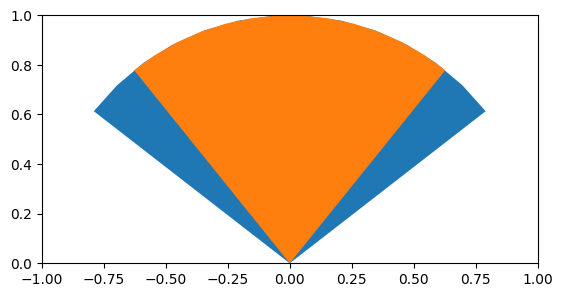

In [5]:
def illustrate_geometry(inter_class_angle, intra_class_angle):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, aspect='equal')

    x0 = 0
    y0 = 0
    rho_marker = 1
    n_marker = 14

    theta = np.linspace(-inter_class_angle + np.pi/2, inter_class_angle + np.pi/2, n_marker)
    x = x0 + np.append(0, rho_marker*np.cos(theta))
    y = y0 + np.append(0, rho_marker*np.sin(theta))
    ax.fill(x, y)

    theta = np.linspace(-intra_class_angle + np.pi/2, intra_class_angle + np.pi/2, n_marker)
    x = x0 + np.append(0, rho_marker*np.cos(theta))
    y = y0 + np.append(0, rho_marker*np.sin(theta))
    ax.fill(x, y)

    plt.xlim([-1, 1])
    plt.ylim([0, 1])
    plt.show()
    
illustrate_geometry(inter_class_angle, intra_class_angle)

We can estimate the capacity now that we have the inter-class and intra-class angles. In the estimate, we also account for a desired false-accept rate threshold ($\delta$ in the paper).

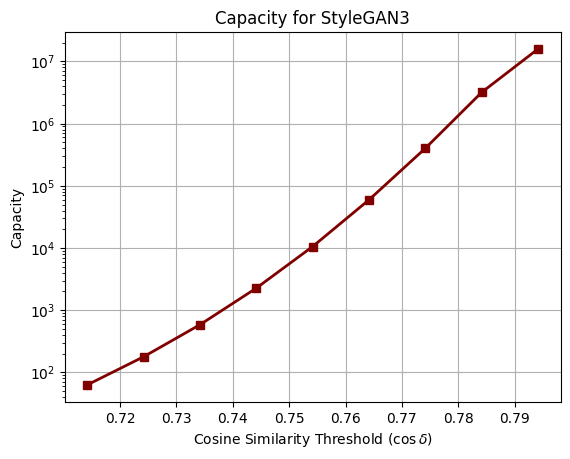

In [6]:
d = X.shape[1] # dimensionality of the feature space

# account for the desired false positive rate threshold
step = 0.01
cos_delta = np.arange(min(threshold) - step * 2, max(threshold) + step * 2, step)
sin_delta = np.sqrt(1 - cos_delta**2)

capacity = ratio_hyperspherical_caps(
    inter_class_angle,
    intra_class_angle,
    cos_delta,
    sin_delta,
    d
)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(cos_delta, capacity, "-s", lw=2, color=(0.5, 0, 0))
ax.set_xlabel(r'Cosine Similarity Threshold ($\cos\delta$)')
ax.set_ylabel('Capacity')
ax.set_yscale('log')
ax.set_title('Capacity for StyleGAN3')
ax.grid(True)

plt.show()

# Capacity for class-conditional generative models (DCFace)

In [7]:
X, df = load_features('dcface', 'arcface', metadata_file=None, root_path=None)

max_samples = 10000 # set this to save memory
if X.shape[0] > max_samples:
    X = X[:max_samples, :]
    df = df[:max_samples]

From the features, we first estimate the inter-class solid angle spanned by all images. To account for outliers, we ignore 5% of the similarity scores.

In [8]:
total_angle, _1, _2 = get_cosine_bounds(X, quantile=0.05)
inter_class_angle = total_angle / 2
inter_class_angle = inter_class_angle * np.pi / 180 # in radians
print("Inter-class angle is {:.2f} radians".format(inter_class_angle))

Inter-class angle is 0.90 radians


The solid angle corresponding to the intra-class variation can be estimated from the intra-class similarity scores for a class-conditional model.

In [54]:
ids = df['ids']
ids = np.array([int(_) for _ in ids])
unique_ids = np.unique(ids)

min_cos_vals_temp = []

for i in unique_ids:
    where_idx = ids == i
    feat_ = X[where_idx]
    cosine_dist = np.dot(feat_, feat_.transpose())
    min_val = np.min(cosine_dist, axis=1)
    min_cos_vals_temp.append(np.min(min_val))
min_cos_vals_temp = np.array(min_cos_vals_temp)

There are many classes (identities) in the dataset. Each class has a different amount of intra-class variation. We choose one of the classes as a representative class. While many choices are possible, we choose the class with the median intra-class variation. We estimate the intra-class solid angle for this class.

This is the only difference between capacity estimates for a class-conditional vs. an unconditional generative face model.

In [63]:
min_cos_vals = np.sort(min_cos_vals_temp)
min_cos_vals = min_cos_vals[min_cos_vals < 0.9]

intra_class_med_cos_val = np.median(np.cos(np.arccos(min_cos_vals)))
intra_class_min_cos_val = np.min(np.cos(np.arccos(min_cos_vals)))
intra_class_max_cos_val = np.max(np.cos(np.arccos(min_cos_vals)))
              
intra_class_angle_med = math.acos(intra_class_med_cos_val) / 2
intra_class_angle_min = math.acos(intra_class_max_cos_val) / 2
intra_class_angle_max = math.acos(intra_class_min_cos_val) / 2

print("Intra-class angle is {:.2f},{:.2f},{:.2f} radians".format(intra_class_angle_med, intra_class_angle_min, intra_class_angle_max))

Intra-class angle is 0.73,0.62,0.84 radians


We illustrate the geometry of the problem if the same features were to lie in a 2-dimensional space. Of course, the features are in a $n$-dimensional space instead.

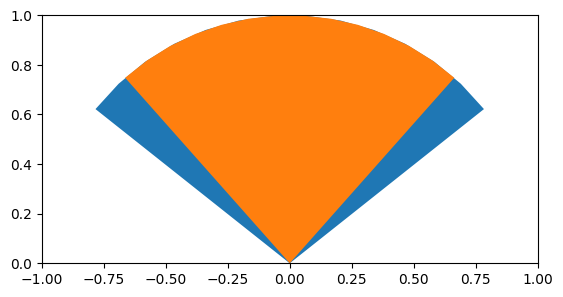

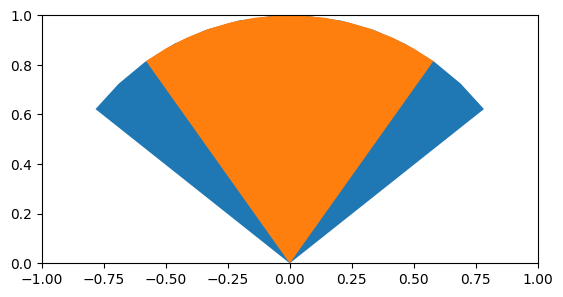

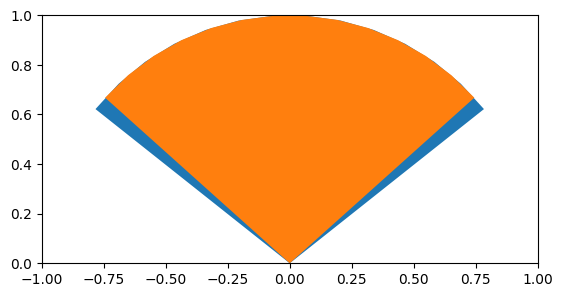

In [64]:
illustrate_geometry(inter_class_angle, intra_class_angle_med)
illustrate_geometry(inter_class_angle, intra_class_angle_min)
illustrate_geometry(inter_class_angle, intra_class_angle_max)

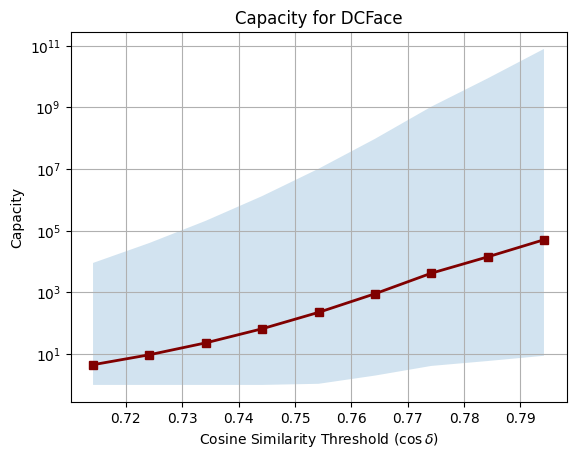

In [65]:
d = X.shape[1] # dimensionality of the feature space

# account for the desired false positive rate threshold
step = 0.01
cos_delta = np.arange(min(threshold) - step * 2, max(threshold) + step * 2, step)
sin_delta = np.sqrt(1 - cos_delta**2)

capacity_med = ratio_hyperspherical_caps(
    inter_class_angle,
    intra_class_angle_med,
    cos_delta,
    sin_delta,
    d
)

capacity_min = ratio_hyperspherical_caps(
    inter_class_angle,
    intra_class_angle_min,
    cos_delta,
    sin_delta,
    d
)

capacity_max = ratio_hyperspherical_caps(
    inter_class_angle,
    intra_class_angle_max,
    cos_delta,
    sin_delta,
    d
)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.fill_between(cos_delta, capacity_min, capacity_max, alpha=0.2)
plt.plot(cos_delta, capacity_med, "-s", lw=2, color=(0.5, 0, 0))
ax.set_xlabel(r'Cosine Similarity Threshold ($\cos\delta$)')
ax.set_ylabel('Capacity')
ax.set_yscale('log')
ax.set_title('Capacity for DCFace')
ax.grid(True)

plt.show()